# Method 9 - Best Minus Rest Top 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 5].copy()                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

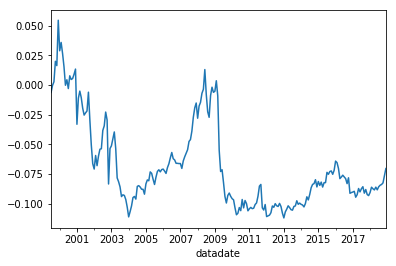

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.054634
2000-12-31   -0.039058
2001-12-31   -0.078777
2002-12-31    0.013721
2003-12-31   -0.052236
2004-12-31    0.012230
2005-12-31    0.022855
2006-12-31    0.005448
2007-12-31    0.054691
2008-12-31    0.009156
2009-12-31   -0.088274
2010-12-31   -0.013464
2011-12-31    0.005927
2012-12-31   -0.008058
2013-12-31    0.009468
2014-12-31    0.015152
2015-12-31    0.015374
2016-12-31   -0.020254
2017-12-31   -0.002808
2018-12-31    0.025127
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     44.99
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.46e-28
Time:                        20:42:37   Log-Likelihood:                 818.59
No. Observations:                 234   AIC:                            -1627.
Df Residuals:                     229   BIC:                            -1610.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -1.152      0.251      -0.002       0.000
mktrf         -0.0244      0.014     -1.765      0.079      -0.052       0.003
me            -0.0072      0.016     -0.451      0.653      -0.039       0.024
ia            -0.1361      0.024     -5.580      0.000      -0.184      -0.088
roe            0.1970      0.021      9.433      0.000       0.156       0.238
==============================================================================
Omnibus:                       50.017   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              679.953
Skew:                          -0.231   Prob(JB):                    2.24e-148
Kurtosis:                      11.338   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     14.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-10
Time:                        20:42:37   Log-Likelihood:                 818.59
No. Observations:                 234   AIC:                            -1627.
Df Residuals:                     229   BIC:                            -1610.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -1.043      0.297      -0.002       0.001
mktrf         -0.0244      0.016     -1.548      0.122      -0.055       0.006
me            -0.0072      0.033     -0.223      0.824      -0.071       0.056
ia            -0.1361      0.064     -2.129      0.033      -0.261      -0.011
roe            0.1970      0.040      4.964      0.000       0.119       0.275
==============================================================================
Omnibus:                       50.017   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              679.953
Skew:                          -0.231   Prob(JB):                    2.24e-148
Kurtosis:                      11.338   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     15.37
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.77e-11
Time:                        20:42:37   Log-Likelihood:                 818.59
No. Observations:                 234   AIC:                            -1627.
Df Residuals:                     229   BIC:                            -1610.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.922      0.356      -0.002       0.001
mktrf         -0.0244      0.015     -1.611      0.107      -0.054       0.005
me            -0.0072      0.035     -0.208      0.836      -0.076       0.061
ia            -0.1361      0.058     -2.351      0.019      -0.250      -0.023
roe            0.1970      0.041      4.811      0.000       0.117       0.277
==============================================================================
Omnibus:                       50.017   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              679.953
Skew:                          -0.231   Prob(JB):                    2.24e-148
Kurtosis:                      11.338   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     18.45
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.23e-15
Time:                        20:42:37   Log-Likelihood:                 790.50
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     228   BIC:                            -1548.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.121e-05      0.001     -0.054      0.957      -0.001       0.001
mktrf         -0.0584      0.016     -3.738      0.000      -0.089      -0.028
smb           -0.0350      0.021     -1.697      0.091      -0.076       0.006
hml           -0.0812      0.024     -3.339      0.001      -0.129      -0.033
rmw            0.0982      0.027      3.573      0.000       0.044       0.152
cma           -0.0367      0.035     -1.050      0.295      -0.106       0.032
==============================================================================
Omnibus:                       80.757   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              981.052
Skew:                          -0.953   Prob(JB):                    9.27e-214
Kurtosis:                      12.848   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     21.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.41e-17
Time:                        20:42:37   Log-Likelihood:                 790.50
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     228   BIC:                            -1548.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.121e-05      0.001     -0.052      0.959      -0.001       0.001
mktrf         -0.0584      0.015     -3.906      0.000      -0.088      -0.029
smb           -0.0350      0.035     -0.988      0.323      -0.104       0.034
hml           -0.0812      0.033     -2.445      0.014      -0.146      -0.016
rmw            0.0982      0.050      1.976      0.048       0.001       0.196
cma           -0.0367      0.092     -0.398      0.691      -0.217       0.144
==============================================================================
Omnibus:                       80.757   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              981.052
Skew:                          -0.953   Prob(JB):                    9.27e-214
Kurtosis:                      12.848   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     25.35
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.66e-20
Time:                        20:42:37   Log-Likelihood:                 790.50
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     228   BIC:                            -1548.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.121e-05      0.001     -0.046      0.963      -0.001       0.001
mktrf         -0.0584      0.014     -4.241      0.000      -0.085      -0.031
smb           -0.0350      0.032     -1.087      0.277      -0.098       0.028
hml           -0.0812      0.034     -2.397      0.017      -0.148      -0.015
rmw            0.0982      0.052      1.883      0.060      -0.004       0.200
cma           -0.0367      0.095     -0.387      0.699      -0.222       0.149
==============================================================================
Omnibus:                       80.757   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              981.052
Skew:                          -0.953   Prob(JB):                    9.27e-214
Kurtosis:                      12.848   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     143.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.80e-61
Time:                        20:42:37   Log-Likelihood:                 897.73
No. Observations:                 234   AIC:                            -1785.
Df Residuals:                     229   BIC:                            -1768.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.427      0.155      -0.001       0.000
mktrf         -0.0070      0.009     -0.770      0.442      -0.025       0.011
smb           -0.1180      0.011    -10.432      0.000      -0.140      -0.096
hml           -0.0425      0.011     -3.786      0.000      -0.065      -0.020
umd            0.1438      0.007     19.511      0.000       0.129       0.158
==============================================================================
Omnibus:                       48.680   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.951
Skew:                          -0.450   Prob(JB):                     4.34e-94
Kurtosis:                       9.579   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     37.88
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-24
Time:                        20:42:37   Log-Likelihood:                 897.73
No. Observations:                 234   AIC:                            -1785.
Df Residuals:                     229   BIC:                            -1768.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.300      0.194      -0.001       0.000
mktrf         -0.0070      0.013     -0.537      0.591      -0.032       0.018
smb           -0.1180      0.012     -9.576      0.000      -0.142      -0.094
hml           -0.0425      0.012     -3.518      0.000      -0.066      -0.019
umd            0.1438      0.016      8.776      0.000       0.112       0.176
==============================================================================
Omnibus:                       48.680   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.951
Skew:                          -0.450   Prob(JB):                     4.34e-94
Kurtosis:                       9.579   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     29.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-19
Time:                        20:42:37   Log-Likelihood:                 897.73
No. Observations:                 234   AIC:                            -1785.
Df Residuals:                     229   BIC:                            -1768.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.143      0.253      -0.001       0.000
mktrf         -0.0070      0.014     -0.495      0.620      -0.035       0.021
smb           -0.1180      0.012     -9.630      0.000      -0.142      -0.094
hml           -0.0425      0.011     -3.731      0.000      -0.065      -0.020
umd            0.1438      0.018      8.096      0.000       0.109       0.179
==============================================================================
Omnibus:                       48.680   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.951
Skew:                          -0.450   Prob(JB):                     4.34e-94
Kurtosis:                       9.579   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     27.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.83e-16
Time:                        20:42:37   Log-Likelihood:                 394.16
No. Observations:                 120   AIC:                            -778.3
Df Residuals:                     115   BIC:                            -764.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.679      0.096      -0.003       0.000
mktrf         -0.0022      0.024     -0.093      0.926      -0.049       0.045
me             0.0263      0.024      1.115      0.267      -0.020       0.073
ia            -0.1749      0.037     -4.739      0.000      -0.248      -0.102
roe            0.2616      0.033      8.010      0.000       0.197       0.326
==============================================================================
Omnibus:                       20.277   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.124
Skew:                           0.137   Prob(JB):                     2.01e-24
Kurtosis:                       7.664   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     22.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.89e-14
Time:                        20:42:37   Log-Likelihood:                 394.16
No. Observations:                 120   AIC:                            -778.3
Df Residuals:                     115   BIC:                            -764.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.590      0.112      -0.003       0.000
mktrf         -0.0022      0.020     -0.110      0.912      -0.042       0.037
me             0.0263      0.038      0.696      0.486      -0.048       0.100
ia            -0.1749      0.080     -2.196      0.028      -0.331      -0.019
roe            0.2616      0.039      6.726      0.000       0.185       0.338
==============================================================================
Omnibus:                       20.277   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.124
Skew:                           0.137   Prob(JB):                     2.01e-24
Kurtosis:                       7.664   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     27.58
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.65e-16
Time:                        20:42:37   Log-Likelihood:                 394.16
No. Observations:                 120   AIC:                            -778.3
Df Residuals:                     115   BIC:                            -764.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.417      0.156      -0.004       0.001
mktrf         -0.0022      0.018     -0.122      0.903      -0.038       0.034
me             0.0263      0.041      0.637      0.524      -0.055       0.107
ia            -0.1749      0.073     -2.393      0.017      -0.318      -0.032
roe            0.2616      0.036      7.329      0.000       0.192       0.332
==============================================================================
Omnibus:                       20.277   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.124
Skew:                           0.137   Prob(JB):                     2.01e-24
Kurtosis:                       7.664   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     8.317
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.92e-07
Time:                        20:42:37   Log-Likelihood:                 372.26
No. Observations:                 120   AIC:                            -732.5
Df Residuals:                     114   BIC:                            -715.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.725      0.470      -0.003       0.001
mktrf         -0.0687      0.030     -2.263      0.026      -0.129      -0.009
smb           -0.0117      0.034     -0.339      0.735      -0.080       0.056
hml           -0.1013      0.042     -2.407      0.018      -0.185      -0.018
rmw            0.1266      0.050      2.550      0.012       0.028       0.225
cma           -0.0471      0.054     -0.865      0.389      -0.155       0.061
==============================================================================
Omnibus:                       27.969   Durbin-Watson:                   2.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.088
Skew:                          -0.629   Prob(JB):                     1.87e-27
Kurtosis:                       7.799   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     11.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.63e-09
Time:                        20:42:37   Log-Likelihood:                 372.26
No. Observations:                 120   AIC:                            -732.5
Df Residuals:                     114   BIC:                            -715.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.691      0.490      -0.003       0.001
mktrf         -0.0687      0.028     -2.456      0.014      -0.123      -0.014
smb           -0.0117      0.049     -0.240      0.810      -0.107       0.084
hml           -0.1013      0.043     -2.355      0.019      -0.186      -0.017
rmw            0.1266      0.061      2.063      0.039       0.006       0.247
cma           -0.0471      0.114     -0.414      0.679      -0.270       0.176
==============================================================================
Omnibus:                       27.969   Durbin-Watson:                   2.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.088
Skew:                          -0.629   Prob(JB):                     1.87e-27
Kurtosis:                       7.799   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     16.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.68e-12
Time:                        20:42:37   Log-Likelihood:                 372.26
No. Observations:                 120   AIC:                            -732.5
Df Residuals:                     114   BIC:                            -715.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.609      0.542      -0.003       0.002
mktrf         -0.0687      0.026     -2.591      0.010      -0.121      -0.017
smb           -0.0117      0.043     -0.273      0.785      -0.095       0.072
hml           -0.1013      0.041     -2.480      0.013      -0.181      -0.021
rmw            0.1266      0.060      2.093      0.036       0.008       0.245
cma           -0.0471      0.116     -0.405      0.686      -0.275       0.181
==============================================================================
Omnibus:                       27.969   Durbin-Watson:                   2.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.088
Skew:                          -0.629   Prob(JB):                     1.87e-27
Kurtosis:                       7.799   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     96.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.94e-36
Time:                        20:42:37   Log-Likelihood:                 442.05
No. Observations:                 120   AIC:                            -874.1
Df Residuals:                     115   BIC:                            -860.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.178      0.241      -0.002       0.000
mktrf          0.0099      0.014      0.704      0.483      -0.018       0.038
smb           -0.1355      0.016     -8.439      0.000      -0.167      -0.104
hml           -0.0525      0.016     -3.264      0.001      -0.084      -0.021
umd            0.1658      0.010     16.723      0.000       0.146       0.185
==============================================================================
Omnibus:                       18.888   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.386
Skew:                          -0.288   Prob(JB):                     1.57e-17
Kurtosis:                       6.892   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     33.38
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.82e-18
Time:                        20:42:37   Log-Likelihood:                 442.05
No. Observations:                 120   AIC:                            -874.1
Df Residuals:                     115   BIC:                            -860.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.092      0.275      -0.002       0.001
mktrf          0.0099      0.015      0.676      0.499      -0.019       0.039
smb           -0.1355      0.014     -9.364      0.000      -0.164      -0.107
hml           -0.0525      0.014     -3.843      0.000      -0.079      -0.026
umd            0.1658      0.017      9.565      0.000       0.132       0.200
==============================================================================
Omnibus:                       18.888   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.386
Skew:                          -0.288   Prob(JB):                     1.57e-17
Kurtosis:                       6.892   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     47.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-23
Time:                        20:42:37   Log-Likelihood:                 442.05
No. Observations:                 120   AIC:                            -874.1
Df Residuals:                     115   BIC:                            -860.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.971      0.331      -0.002       0.001
mktrf          0.0099      0.015      0.662      0.508      -0.019       0.039
smb           -0.1355      0.014     -9.675      0.000      -0.163      -0.108
hml           -0.0525      0.014     -3.799      0.000      -0.080      -0.025
umd            0.1658      0.017      9.577      0.000       0.132       0.200
==============================================================================
Omnibus:                       18.888   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.386
Skew:                          -0.288   Prob(JB):                     1.57e-17
Kurtosis:                       6.892   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     34.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.51e-18
Time:                        20:42:37   Log-Likelihood:                 485.96
No. Observations:                 114   AIC:                            -961.9
Df Residuals:                     109   BIC:                            -948.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.935      0.352      -0.000       0.001
mktrf         -0.0327      0.010     -3.189      0.002      -0.053      -0.012
me            -0.0898      0.016     -5.675      0.000      -0.121      -0.058
ia            -0.0690      0.022     -3.146      0.002      -0.113      -0.026
roe            0.0642      0.019      3.331      0.001       0.026       0.102
==============================================================================
Omnibus:                       20.263   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.522
Skew:                          -0.682   Prob(JB):                     3.54e-10
Kurtosis:                       5.702   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     50.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.20e-24
Time:                        20:42:37   Log-Likelihood:                 485.96
No. Observations:                 114   AIC:                            -961.9
Df Residuals:                     109   BIC:                            -948.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.096      0.273      -0.000       0.001
mktrf         -0.0327      0.012     -2.658      0.008      -0.057      -0.009
me            -0.0898      0.016     -5.445      0.000      -0.122      -0.057
ia            -0.0690      0.024     -2.910      0.004      -0.116      -0.023
roe            0.0642      0.022      2.885      0.004       0.021       0.108
==============================================================================
Omnibus:                       20.263   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.522
Skew:                          -0.682   Prob(JB):                     3.54e-10
Kurtosis:                       5.702   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     64.19
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.69e-28
Time:                        20:42:37   Log-Likelihood:                 485.96
No. Observations:                 114   AIC:                            -961.9
Df Residuals:                     109   BIC:                            -948.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.074      0.283      -0.000       0.001
mktrf         -0.0327      0.012     -2.648      0.008      -0.057      -0.008
me            -0.0898      0.016     -5.569      0.000      -0.121      -0.058
ia            -0.0690      0.027     -2.605      0.009      -0.121      -0.017
roe            0.0642      0.022      2.914      0.004       0.021       0.107
==============================================================================
Omnibus:                       20.263   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.522
Skew:                          -0.682   Prob(JB):                     3.54e-10
Kurtosis:                       5.702   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     29.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.52e-19
Time:                        20:42:37   Log-Likelihood:                 489.02
No. Observations:                 114   AIC:                            -966.0
Df Residuals:                     108   BIC:                            -949.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.177      0.242      -0.000       0.001
mktrf         -0.0366      0.010     -3.833      0.000      -0.056      -0.018
smb           -0.0852      0.016     -5.490      0.000      -0.116      -0.054
hml           -0.0521      0.020     -2.632      0.010      -0.091      -0.013
rmw            0.0448      0.024      1.848      0.067      -0.003       0.093
cma           -0.0325      0.031     -1.056      0.293      -0.093       0.028
==============================================================================
Omnibus:                       16.498   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.364
Skew:                          -0.616   Prob(JB):                     4.20e-07
Kurtosis:                       5.160   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     77.82
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.38e-34
Time:                        20:42:37   Log-Likelihood:                 489.02
No. Observations:                 114   AIC:                            -966.0
Df Residuals:                     108   BIC:                            -949.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.522      0.128      -0.000       0.001
mktrf         -0.0366      0.010     -3.632      0.000      -0.056      -0.017
smb           -0.0852      0.011     -7.442      0.000      -0.108      -0.063
hml           -0.0521      0.019     -2.773      0.006      -0.089      -0.015
rmw            0.0448      0.020      2.292      0.022       0.006       0.083
cma           -0.0325      0.027     -1.196      0.232      -0.086       0.021
==============================================================================
Omnibus:                       16.498   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.364
Skew:                          -0.616   Prob(JB):                     4.20e-07
Kurtosis:                       5.160   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     137.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.57e-45
Time:                        20:42:37   Log-Likelihood:                 489.02
No. Observations:                 114   AIC:                            -966.0
Df Residuals:                     108   BIC:                            -949.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.637      0.102   -7.92e-05       0.001
mktrf         -0.0366      0.010     -3.572      0.000      -0.057      -0.017
smb           -0.0852      0.011     -7.776      0.000      -0.107      -0.064
hml           -0.0521      0.018     -2.907      0.004      -0.087      -0.017
rmw            0.0448      0.016      2.789      0.005       0.013       0.076
cma           -0.0325      0.030     -1.099      0.272      -0.090       0.025
==============================================================================
Omnibus:                       16.498   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.364
Skew:                          -0.616   Prob(JB):                     4.20e-07
Kurtosis:                       5.160   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     54.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.43e-25
Time:                        20:42:37   Log-Likelihood:                 502.14
No. Observations:                 114   AIC:                            -994.3
Df Residuals:                     109   BIC:                            -980.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.711      0.479      -0.000       0.001
mktrf         -0.0312      0.008     -3.699      0.000      -0.048      -0.014
smb           -0.0995      0.013     -7.577      0.000      -0.126      -0.074
hml           -0.0498      0.014     -3.679      0.000      -0.077      -0.023
umd            0.0597      0.010      5.851      0.000       0.039       0.080
==============================================================================
Omnibus:                       10.156   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.983
Skew:                          -0.420   Prob(JB):                     0.000558
Kurtosis:                       4.565   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     60.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.35e-27
Time:                        20:42:37   Log-Likelihood:                 502.14
No. Observations:                 114   AIC:                            -994.3
Df Residuals:                     109   BIC:                            -980.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.097      0.273      -0.000       0.001
mktrf         -0.0312      0.009     -3.662      0.000      -0.048      -0.014
smb           -0.0995      0.013     -7.704      0.000      -0.125      -0.074
hml           -0.0498      0.014     -3.663      0.000      -0.076      -0.023
umd            0.0597      0.010      6.077      0.000       0.040       0.079
==============================================================================
Omnibus:                       10.156   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.983
Skew:                          -0.420   Prob(JB):                     0.000558
Kurtosis:                       4.565   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     46.28
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.13e-22
Time:                        20:42:37   Log-Likelihood:                 502.14
No. Observations:                 114   AIC:                            -994.3
Df Residuals:                     109   BIC:                            -980.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.312      0.189      -0.000       0.001
mktrf         -0.0312      0.009     -3.559      0.000      -0.048      -0.014
smb           -0.0995      0.013     -7.691      0.000      -0.125      -0.074
hml           -0.0498      0.015     -3.312      0.001      -0.079      -0.020
umd            0.0597      0.010      6.099      0.000       0.041       0.079
==============================================================================
Omnibus:                       10.156   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.983
Skew:                          -0.420   Prob(JB):                     0.000558
Kurtosis:                       4.565   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""